### DATA PREPROCESSING

In [4]:
%reload_ext autoreload
%autoreload 2

# imports
import os
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from statsmodels.stats.multicomp import pairwise_tukeyhsd


from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

sns.set_theme()

In [5]:
import helpers

# Data Loading , the imprt_movies_data function load and preprocess the data
movies,characters, plot_summaries = helpers.import_movies_data("./data/")


movies.shape

/Users/zhouyanling/Downloads/CS-401/ada/ada-2023-project-zalix/helpers.py:73: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movies["year_released"] = pd.to_datetime(


(14369, 13)

### GENRE

In the realm of movies, genres play a crucial role in defining the stylistic and thematic elements that shape a film's identity. Unlike strict boundaries, many movies embrace a blend of genres, creating a rich tapestry of storytelling that transcends traditional categorizations. From action-packed adventures with a touch of romance to thought-provoking science fiction infused with elements of comedy, the interplay of multiple genres adds layers of complexity and intrigue to cinematic experiences. Whether it's a thrilling action-comedy, a romantic fantasy epic, or a crime drama with elements of mystery, the fusion of genres allows filmmakers to craft narratives that appeal to a diverse audience, offering a dynamic and ever-evolving landscape within the world of cinema.

In our evaluation of cinematic quality, the role of genres in influencing ratings emerges as a noteworthy consideration. The objectives of this analysis encompass the exploration of various research questions:

- Identification of the top 10 most prolific genres in the history of cinema.
- Evaluation of the proportion of exemplary films within the aforementioned 10 most prolific genres, defined here as those with a rating of 7 or higher.
- Examination of the intersection between genres and the temporal variable, aiming to identify "golden eras" marked by periods with the highest number of highly-rated films within a specific genre. This will be accomplished through the visualization of highly-rated movie counts per decade.
- Scrutiny of genre combinations to discern noteworthy amalgamations during specific time periods. This aspect of the analysis will involve the generation of a bar chart illustrating the ratio of highly-rated movies relative to each decade.

(784,)
 "/m/07s9rl0": "Drama"                    3486
 "/m/01z4y": "Comedy"                     1999
{"/m/01jfsb": "Thriller"                  1566
 "/m/01z4y": "Comedy"}                    1387
 "/m/01g6gs": "Black-and-white"}          1348
                                          ... 
{"/m/03jp5h0": "Archaeology"                 1
 "/m/0fx2s": "Tragedy"}                      1
{"/m/0hj3n11": "Environmental Science"       1
{"/m/01lrrt": "Melodrama"}                   1
{"/m/01lmb_": "Sword and Sandal"             1
Name: count, Length: 784, dtype: int64


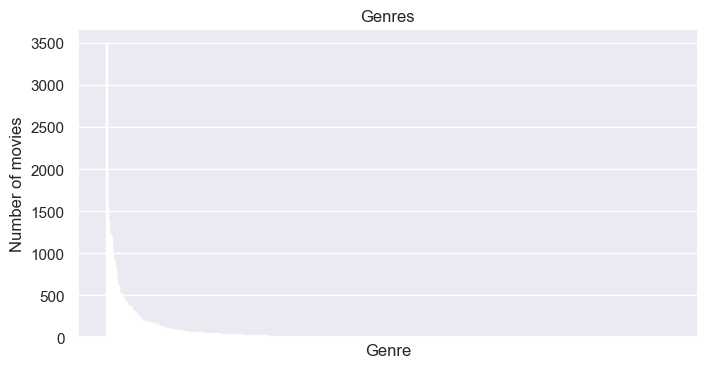

In [6]:
#genres
genres = movies["movie_genres"].str.split(",", expand=True).stack().value_counts()
print(genres.shape)
print(genres)
#plot genres
plt.figure(figsize=(8, 4))
plt.bar(genres.index, genres.values)
#hide x labels
plt.xticks([])
#plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

In [7]:
#extract the main genre
def extract_genres(row):
    try:
        genres_dict = json.loads(row)
        return list(genres_dict.values()) if genres_dict else ['NaN']
    except json.JSONDecodeError:
        return ['NaN']

# Apply the function to create a new 'genre' column
movies['genre'] = movies['movie_genres'].apply(extract_genres)
genre=movies['genre'].explode().copy()
genre=genre[genre!='NaN']
genre=genre.value_counts()
#find the unique genres
unique_genres = genre.index
print(unique_genres)

Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure',
       ...
       'Historical Documentaries', 'Race movie', 'Science fiction Western',
       'Kitchen sink realism', 'Filipino', 'Sci-Fi Thriller',
       'Political Documetary', 'Nuclear warfare', 'Space opera',
       'Revisionist Fairy Tale'],
      dtype='object', name='genre', length=323)


Upon examination of the aforementioned graph, it becomes evident that there are over 700 genres, with a considerable portion having a minimal number of movies, rendering them inconsequential for our analytical purposes. Consequently, we have elected to narrow our focus to the top ten genres, as they not only serve as more representative subsets but also encapsulate the majority of films within our dataset.

In [8]:
# give the top 10 genres that has the largerst number of movies and store them in genre_main
genre_main = genre[:10]
print(genre_main.shape)
print(genre_main.index)

(10,)
Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure'],
      dtype='object', name='genre')


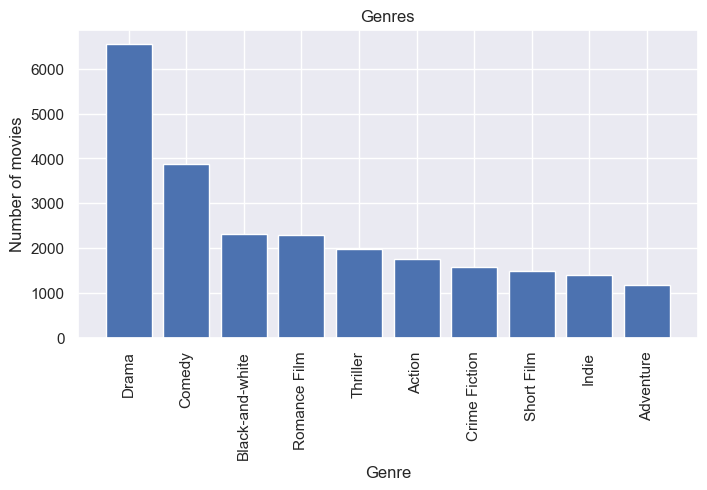

In [9]:
#plot the top 10 genres
plt.figure(figsize=(8, 4))
plt.bar(genre_main.index, genre_main.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()


In [10]:
#filter the movies that have the genres in genre_main, not necessarily the first genre
movies_main = movies[movies['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy()
print(movies_main.shape)
movies_main.head()


(12463, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0,"[Thriller, Science Fiction, Horror, Adventure,..."
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0,"[Short Film, Silent film, Indie, Black-and-whi..."
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0,"[Musical, Comedy, Black-and-white]"
5,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,tt0097499,7.5,31208.0,"[Costume drama, War film, Epic, Period piece, ..."
6,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,tt0058331,7.8,181829.0,"[Children's/Family, Musical, Fantasy, Comedy, ..."


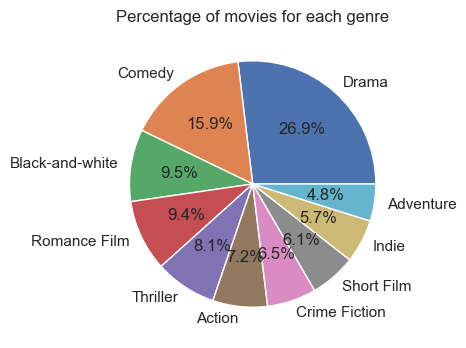

In [11]:
# plot a pie chart for the top 10 genres in the decade 2000-2010 which shows the percentage of the number of movies for each genre in genre_main
movie_genre=movies_main['genre'].explode().value_counts()[genre_main.index]
plt.figure(figsize=(8, 4))
plt.pie(movie_genre.values, labels=movie_genre.index, autopct='%1.1f%%')
plt.title("Percentage of movies for each genre")
plt.show()

Given that our criterion for categorizing "good" movies hinges on those with a rating surpassing 7, we proceed to implement a filtering mechanism. This entails narrowing our focus exclusively to movies meeting this specific high-rating threshold. By concentrating on this subset of films, we aim to glean more targeted insights into the characteristics and trends associated with movies that align with the established criteria for excellence.

(10,)
Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure'],
      dtype='object', name='genre')


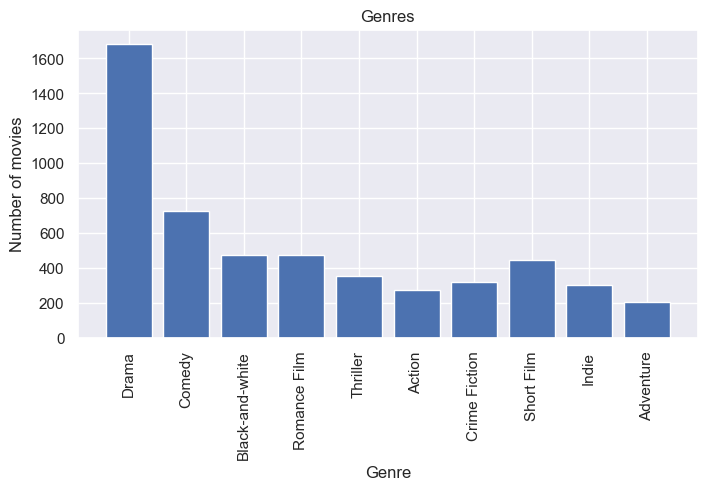

In [12]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_main_filtered= movies_main[movies_main['averageRating']>=7].copy()
#for each genre in genre_main, find the number of movies in movies_main_filter that have the genre
#and plot the number of movies for each genre
genre_main_filtered = movies_main_filtered['genre'].explode().value_counts()[genre_main.index]
print(genre_main_filtered.shape)
print(genre_main_filtered.index)
plt.figure(figsize=(8, 4))
plt.bar(genre_main_filtered.index, genre_main_filtered.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

The graphical representation highlights the prominence of the drama genre, possessing the highest count of highly-rated movies, a figure significantly surpassing other genres. However, it is imperative to consider that the sheer abundance of drama films in the dataset could contribute to this observation. To delve deeper into the matter, we meticulously examine the ratio of high-rated movies to the total number of movies within each genre, providing a more nuanced perspective on the prevalence of quality content within the diverse genres.

(10, 2)


/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_43737/1735292041.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  genre_ratio = pd.concat([genre_ratio, pd.DataFrame({'genre': [g], 'ratio': [ratio]})], ignore_index=True)#sort the dataframe by ratio


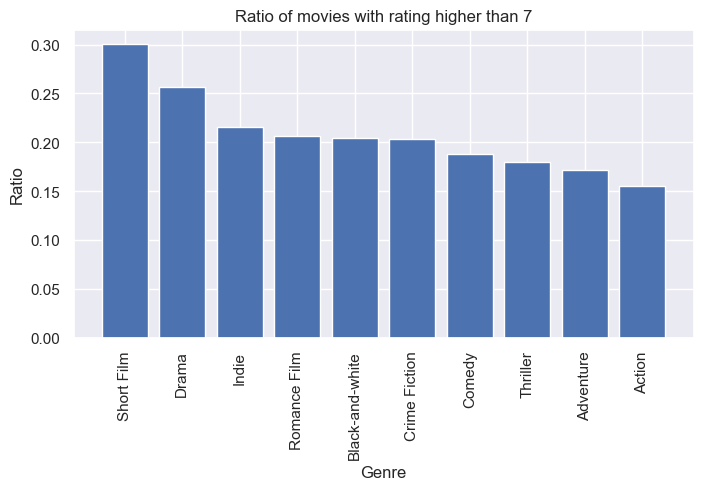

In [13]:
#for each genre, calculate the ratio of movies with rating higher than 7 / total number of movies in that genre
genre_ratio = pd.DataFrame(columns=['genre', 'ratio'])
for g in genre_main.index:
    ratio = len(movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: g in x)]) / len(movies_main[movies_main['genre'].apply(lambda x: g in x)])
    #add the genre and ratio to the dataframe
    genre_ratio = pd.concat([genre_ratio, pd.DataFrame({'genre': [g], 'ratio': [ratio]})], ignore_index=True)#sort the dataframe by ratio
genre_ratio = genre_ratio.sort_values(by='ratio', ascending=False)
print(genre_ratio.shape)
#plot the ratio
plt.figure(figsize=(8, 4))
plt.bar(genre_ratio['genre'], genre_ratio['ratio'])
plt.xticks(rotation=90)
plt.title("Ratio of movies with rating higher than 7")
plt.xlabel("Genre")
plt.ylabel("Ratio")
plt.show()


The graph reveals noteworthy insights into the distribution of highly-rated movies across genres. Notably, short films exhibit the highest ratio of highly-rated movies to the total number of short films, positioning it at the forefront. Drama, despite its prominence in sheer numbers, takes the second position in this ratio analysis. Conversely, adventure and action genres exhibit the lowest ratios, indicating a comparatively lower prevalence of highly-rated movies within these genres. This nuanced examination contributes to a more comprehensive understanding of the quality distribution across various film genres.

Subsequently, we incorporate the temporal variable into our analysis to explore whether certain genres exhibit a notable concentration of highly-rated movies during specific time periods. The objective is to discern if there are temporal intervals wherein a particular genre experiences a significantly higher count of highly-rated movies compared to other periods. This temporal analysis aims to uncover patterns and trends in the distribution of high-quality movies within individual genres across different epochs.

In [14]:
#create a new dataframe with only the top 10 genres and has a rating larger than 7
movies_main = movies[movies["averageRating"] >= 7].copy()
movies_main = movies_main.reset_index(drop=True)
print(movies_main.shape)
movies_main.head()

(3247, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,tt0097499,7.5,31208.0,"[Costume drama, War film, Epic, Period piece, ..."
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,tt0058331,7.8,181829.0,"[Children's/Family, Musical, Fantasy, Comedy, ..."
2,24399617,/m/07s63_7,Bruce Lee: The Lost Interview,1994-11-02,NaN,30.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/02hmvc"": ""Short Film""}",1994,tt0432762,8.6,123.0,[Short Film]
3,8669450,/m/027d9tv,One Six Right,2005-11-25,NaN,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jtdp"": ""Documentary""}",2005,tt0475994,7.9,457.0,[Documentary]
4,164388,/m/015wmt,The Great Santini,1979-10-26,4702575.0,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02h8pkk"": ""Family Drama"", ""/m/07s9rl0"": ""...",1979,tt0079239,7.2,6812.0,"[Family Drama, Drama]"


In [15]:
# plot the number of movies for a genre for each decade
def plot_decade_genre(genre):
    # create a new dataframe with only the genre
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre in x)].copy()
    # create a new column with the decade
    movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.figure(figsize=(8, 4))
    plt.bar(movies_genre_decade.index, movies_genre_decade.values)
    plt.title("Number of movies for each decade")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()

# apply the function to the top 10 genres
interact(plot_decade_genre, genre=genre_main.index,sharey=True)

interactive(children=(Dropdown(description='genre', options=('Drama', 'Comedy', 'Black-and-white', 'Romance Fi…

<function __main__.plot_decade_genre(genre)>

In [16]:
# now we explore the combination of genres
# plot the number of movies for each combination of genres of the top 10 genres in each decade
plt.figure(figsize=(8, 4))
def plot_genre_combination_decade(genre1, genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new column with the decade
    movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade

    plt.bar(movies_genre_decade.index, movies_genre_decade.values)
    plt.title("Number of movies for each decade of genre")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()


# apply the function to the top 10 genres
interact(plot_genre_combination_decade, genre1=genre_main.index, genre2=genre_main.index)

<Figure size 800x400 with 0 Axes>

interactive(children=(Dropdown(description='genre1', options=('Drama', 'Comedy', 'Black-and-white', 'Romance F…

<function __main__.plot_genre_combination_decade(genre1, genre2)>

The graphical representation highlights two notable surges in the number of highly-rated movies throughout history: one during the 1930s and another in the 2000s.  During these intervals, there is a pronounced surge in the number of movies receiving high ratings. Intriguingly, in the aftermath of both periods, there is a noticeable decline, coinciding with two significant economic crises—the Great Depression in the 1930s and the global financial crisis of 2008. The observed correlation between economic downturns and fluctuations in the production and reception of high-quality movies prompts an exploration into the intricate dynamics at play during times of economic instability. Unraveling the contextual factors influencing these trends can provide valuable insights into the evolving landscape of the film industry across different historical epochs.

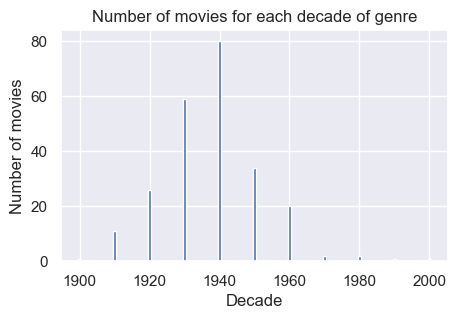

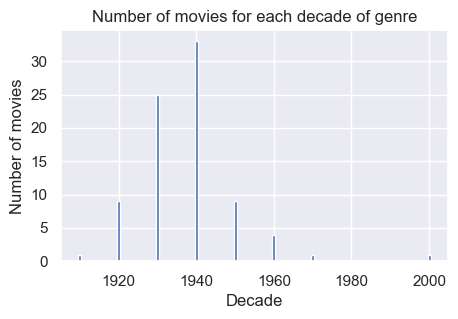

In [17]:
plt.figure(figsize=(5,3))
plot_genre_combination_decade('Drama', 'Black-and-white')
plt.figure(figsize=(5,3))
plot_genre_combination_decade('Romance Film', 'Black-and-white')

It comes as no surprise that a significant proportion of highly-rated movies are in black-and-white, with a notable concentration within the drama genre. This observation underscores the enduring appeal of the black-and-white aesthetic in conveying the nuanced themes often associated with dramatic narratives. Furthermore, within the realm of black-and-white films, the comedy and romance genres emerge as particularly prominent, constituting the majority of high-rated movies. This alignment suggests a unique intersection of visual style and storytelling elements that contribute to the success and acclaim of black-and-white comedies and romances. A more in-depth exploration of these specific films can shed light on the distinctive qualities that make them stand out within the broader landscape of high-quality cinema.

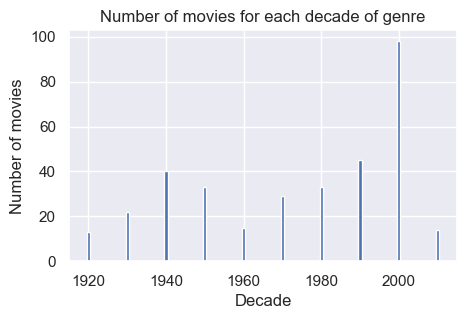

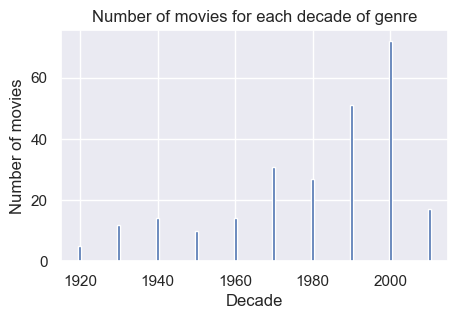

In [18]:
plt.figure(figsize=(5,3))
plot_genre_combination_decade('Drama', 'Romance Film')
plt.figure(figsize=(5,3))
plot_genre_combination_decade('Drama', 'Comedy')

Delving into the significant surge observed in the 2000s, we aim to meticulously examine the intricate effects resulting from combinations of genres during this prolific period. By scrutinizing the interplay between different genres within this temporal frame, we seek to unravel patterns, preferences, and potential synergies that contributed to the remarkable increase in the number of highly-rated movies. This focused analysis on genre combinations promises to unveil insights into the evolving tastes, creative trends, and collaborative dynamics that defined the cinematic landscape during this particular era, enriching our understanding of the multifaceted factors influencing the success of movies.

In [19]:
# now lets focus on the years after 2000
# create a new dataframe with only the movies after 2000
movies_2000 = movies_main[(movies_main['year_released'] >= 2000)].copy()
# do the above analysis for every year in the decade
def plot_genre_combination_year(genre1,genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_2000[movies_2000['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new dataframe with the number of movies for each year
    movies_genre_year = movies_genre['year_released'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.figure(figsize=(8, 4))
    plt.bar(movies_genre_year.index, movies_genre_year.values)
    plt.title("Number of movies for each year after 2000")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()

# apply the function to the top 10 genres
interact(plot_genre_combination_year, genre1=genre_main.index, genre2=genre_main.index)

interactive(children=(Dropdown(description='genre1', options=('Drama', 'Comedy', 'Black-and-white', 'Romance F…

<function __main__.plot_genre_combination_year(genre1, genre2)>

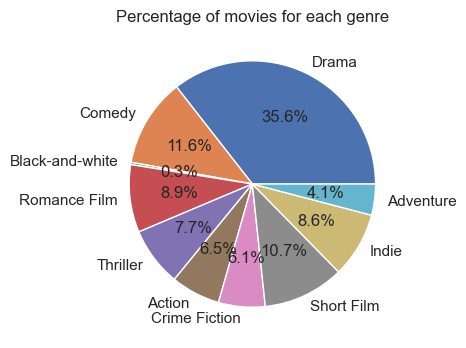

In [20]:
#plot a pie chart for the top 10 genres in the decade 2000-2010 which shows the percentage of the number of movies for each genre in genre_main
movie_genre=movies_2000['genre'].explode().value_counts()[genre_main.index]
plt.figure(figsize=(8, 4))
plt.pie(movie_genre.values, labels=movie_genre.index, autopct='%1.1f%%')
plt.title("Percentage of movies for each genre")
plt.show()

From the comprehensive analysis presented above, a discernible trend emerges, indicating that the drama genre has consistently dominated the cinematic landscape. This dominance is reflected in both the largest number of total movies across all genres. The enduring popularity and prevalence of drama underscore its universal appeal, serving as a versatile and enduring vehicle for storytelling that resonates with diverse audiences. As we continue to explore the intricacies of genre dynamics, the prominence of drama stands as a testament to its enduring significance within the ever-evolving world of cinema.

### DURATION

The duration of a movie, a fundamental element in cinematic storytelling, serves as a crucial factor influencing the overall viewing experience and perceived quality. Film durations vary widely, ranging from concise short films to sprawling epics. The impact of a movie's duration on its quality is a nuanced consideration that intertwines with storytelling techniques, pacing, audience engagement, and thematic depth. A well-crafted film can leverage its duration to immerse viewers in its narrative world, allowing for character development, plot intricacies, and emotional resonance. However, an excessively long or brief duration may pose challenges, potentially leading to pacing issues or insufficient exploration of complex themes. This intricate interplay between movie duration and quality underscores the significance of understanding how filmmakers navigate the temporal dimension to create compelling and impactful cinematic experiences.

In [21]:
#duration
#the distribution of runtime and its correlation with rating
print(movies[["movie_runtime", "averageRating"]].count())
duration = movies[["movie_runtime", "averageRating"]].dropna()
duration.count()

movie_runtime    13609
averageRating    14369
dtype: int64


movie_runtime    13609
averageRating    13609
dtype: int64

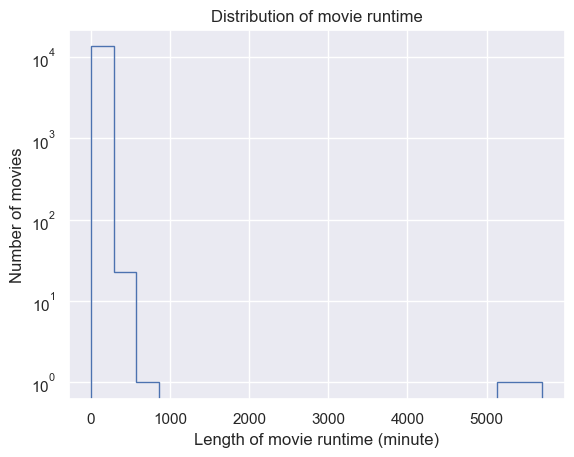

In [22]:
# histogram plot without removing outliers
plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()


Upon examination of the graph presented above, a noteworthy pattern emerges where a considerable number of films exhibit either exceptionally short or excessively long durations, exceeding 5000 minutes. To ensure the precision and reliability of our analysis, it is imperative to address these outliers. Eliminating such extreme values is essential for a more accurate representation of the dataset and will contribute to the robustness of our findings.

Additionally, it is pertinent to acknowledge that short films often have relatively brief durations, which could potentially skew our analysis of runtime for regular feature-length movies. Fortunately, a substantial portion of these short films falls within the category of outliers slated for removal. This strategic refinement of the dataset aims to enhance the integrity of our examination of movie durations and facilitate a more nuanced understanding of the temporal aspects within the cinematic landscape.

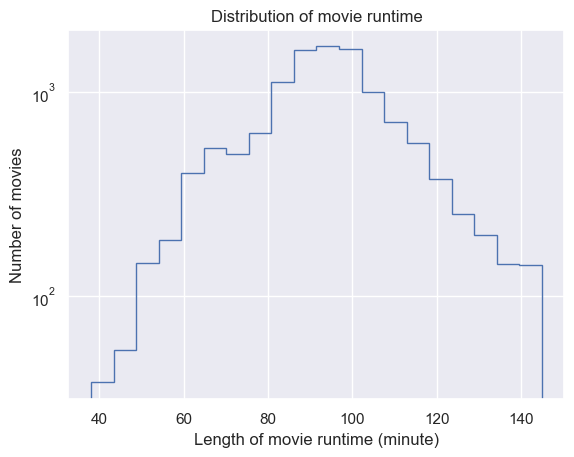

In [23]:
# histogram plot with removing outliers using IQR
q1 = duration["movie_runtime"].quantile(0.25)
q3 = duration["movie_runtime"].quantile(0.75)
iqr = q3 - q1
duration = duration[duration["movie_runtime"] < q3 + 1.5 * iqr]
duration = duration[duration["movie_runtime"] > q1 - 1.5 * iqr]

plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()


/Users/zhouyanling/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zhouyanling/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zhouyanling/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zhouyanling/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and w

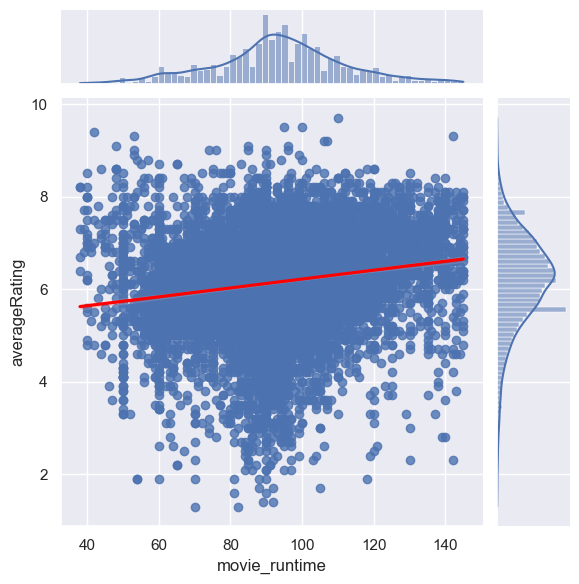

In [24]:
# use sns to plot the scatter plot of runtime and rating with regression line
sns.jointplot(x="movie_runtime", y="averageRating", data=duration, kind="reg",line_kws={"color": "red"})

The preliminary regression analysis indicates a noteworthy trend where longer durations tend to correlate with higher average ratings. This initial observation prompts further investigation to validate and refine our understanding of the relationship between movie duration and audience ratings. While this finding suggests a positive association, additional factors such as genre, thematic content, and storytelling techniques may contribute to a more nuanced interpretation. Therefore, a more in-depth and comprehensive analysis is warranted to ensure a robust understanding of the intricate dynamics influencing movie ratings in relation to their durations.

In [25]:
#perform linear regression on duration data, and plot the regression line
model=smf.ols(formula='averageRating ~ movie_runtime', data=duration)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     374.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           3.26e-82
Time:                        10:39:37   Log-Likelihood:                -16873.
No. Observations:               11874   AIC:                         3.375e+04
Df Residuals:                   11872   BIC:                         3.376e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.2557      0.047    110.670

Our analysis adopts a dual perspective, delineated by two distinct criteria. Firstly, the dataset is bifurcated based on ratings, with a division into two halves. Subsequently, the dataset is segregated based on duration, categorizing movies with a runtime exceeding 80 minutes as long-duration films. Two sets of t-tests are conducted to discern potential statistically significant differences: one examines the mean average duration between high-rating and lower-rating movies, while the other investigates the mean average rating between long-duration and shorter-duration movies. These parallel analyses offer a comprehensive exploration of the interplay between movie ratings, durations, and their potential impact on cinematic characteristics.

In [26]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_high_rating= duration[duration['averageRating']>=7].copy()
movies_non_high_rating= duration[duration['averageRating']<7].copy()
print(movies_high_rating.shape)
print(movies_non_high_rating.shape)


(2459, 2)
(9415, 2)


Conducting a t-test on the runtime variable is imperative to ascertain the presence of a statistically significant distinction between two subsets of movies based on their ratings. Specifically, this analysis aims to discern whether there exists a noteworthy difference in runtime duration between movies with ratings exceeding 7 and those with ratings below 7. By rigorously applying statistical methods, we endeavor to illuminate any discernible patterns or variations in movie runtimes associated with differing rating categories.

In [27]:
#perform a t-test on the runtime of movies with rating higher than 7 and movies with rating lower than 7 to see if there is a significant difference
stats.ttest_ind(a=movies_high_rating["movie_runtime"], b=movies_non_high_rating["movie_runtime"],equal_var=False)

TtestResult(statistic=15.615541110148706, pvalue=3.6823789974589413e-53, df=3435.0436677777066)

In [28]:
#calculate the mean of runtime for movies with rating higher than 7 and movies with rating lower than 7 and their difference
print(movies_high_rating["movie_runtime"].mean())
print(movies_non_high_rating["movie_runtime"].mean())
diff=movies_high_rating["movie_runtime"].mean()-movies_non_high_rating["movie_runtime"].mean()
print(f"The mean difference in duration is:{diff}")

#calculate the percentage of difference
perc=diff/movies_non_high_rating["movie_runtime"].mean()*100
print(f"The percentage difference in duration is:{perc}")

99.47417649450996
92.34965480616039
The mean difference in duration is:7.124521688349574
The percentage difference in duration is:7.714724763512941


Based on the preceding analysis, it is evident that a statistically significant difference exists between the means of movie runtimes for those with ratings exceeding 7 and those with ratings below 7. The mean duration of high-rating movies is found to be 7.71% higher than that of their lower-rated counterparts. This finding suggests a notable variation in runtime characteristics between movies of distinct rating categories, emphasizing the potential influence of audience ratings on the temporal aspects of cinematic storytelling.

In [29]:
#split the movies into two groups, one with movie_runtime>=80 and the other with movie_runtime<80
movies_long_duration=duration[duration["movie_runtime"]>=80]
movies_short_duration=duration[duration["movie_runtime"]<80]

In [30]:
#perform a t-test on the rating of movies with runtime>=80 and movies with runtime<80 to see if there is a significant difference
stats.ttest_ind(a=movies_long_duration["averageRating"], b=movies_short_duration["averageRating"],equal_var=False)

TtestResult(statistic=6.304250491709349, pvalue=3.2633531397026146e-10, df=3444.252730345831)

In [31]:
#calculate the mean of rating for movies with runtime>=80 and movies with runtime<80 and their difference
print(movies_long_duration["averageRating"].mean())
print(movies_short_duration["averageRating"].mean())
diff=movies_long_duration["averageRating"].mean()-movies_short_duration["averageRating"].mean()
print(f"The mean difference in rating is:{diff}")

#calculate the percentage of difference
perc=diff/movies_short_duration["averageRating"].mean()*100
print(f"The percentage difference in rating is:{perc}")


6.185743995008838
6.037749224634471
The mean difference in rating is:0.1479947703743676
The percentage difference in rating is:2.451157954201506


Based on the outcomes presented above, it is evident that a statistically significant difference exists in the means of average ratings between long-duration movies and shorter-duration movies. Specifically, long-duration movies exhibit a higher mean rating of 6.19, contrasting with the mean rating of 6.03 observed for shorter-duration movies. This finding underscores a notable association between the temporal extent of movies and audience ratings, suggesting that longer-duration films tend to garner higher average ratings compared to their shorter-duration counterparts.

### TOPIC DETECTION

In [32]:
plot_summaries.head()

,MovieID,PlotSummary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


After defining the most "liked" genres according to the most ranked movies, we will proceed with the topic analysis among these movies (the most ranked). 
Thus, we will define the most liked topic in each top 5 most liked genres. 

In [33]:


nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
nltk.download('punkt')  
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercasing
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenization and Lemmatization
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 3]
    return tokens

# Apply preprocessing to each PlotSummary
#plot_summaries['processed_plot'] = plot_summaries['PlotSummary'].apply(preprocess)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhouyanling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhouyanling/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhouyanling/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
# movies that have drama as one of their genres
drama_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Drama' in x)].copy()
# from plot_summaries dataset, extract the plot summaries of the drama movies
drama_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(drama_movies['wikipedia_movie_ID'])].copy()

# movies that have comedy as one of their genres
comedy_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Comedy' in x)].copy()
# from plot_summaries dataset, extract the plot summaries of the comedy movies
comedy_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(comedy_movies['wikipedia_movie_ID'])].copy()

# movies that have short film as one of their genres
short_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Short Film' in x)].copy()

# from plot_summaries dataset, extract the plot summaries of the short movies
short_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(short_movies['wikipedia_movie_ID'])].copy()

# movies that have Black-and-white as one of their genres
bw_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Black-and-white' in x)].copy()
# from plot_summaries dataset, extract the plot summaries of the Black-and-white movies
bw_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(bw_movies['wikipedia_movie_ID'])].copy()

# movies that have Romance film as one of their genres
romance_movies = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: 'Romance Film' in x)].copy()
# from plot_summaries dataset, extract the plot summaries of the Romance movies
romance_movies_plot = plot_summaries[plot_summaries['MovieID'].isin(romance_movies['wikipedia_movie_ID'])].copy()




In [35]:
#preprocess the plot summaries of the drama movies and store them in drama_movies_plot['processed_plot']
drama_movies_plot['processed_plot'] = drama_movies_plot['PlotSummary'].apply(preprocess)

# Create a dictionary representation of the documents
dictionary_drama = Dictionary(drama_movies_plot['processed_plot'])

# Filter out words that occur less than 5 documents, or more than 90% of the documents.
dictionary_drama.filter_extremes(no_below=5, no_above=0.95)

# Create a bag-of-words representation of the documents
corpus_drama = [dictionary_drama.doc2bow(doc) for doc in drama_movies_plot['processed_plot']]

In [36]:
#preprocess the plot summaries of the comedy movies and store them in comedy_movies_plot['processed_plot']
comedy_movies_plot['processed_plot'] = comedy_movies_plot['PlotSummary'].apply(preprocess)

#create a dictionary representation of the documents
dictionary_comedy = Dictionary(comedy_movies_plot['processed_plot'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_comedy.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words representation of the documents
corpus_comedy = [dictionary_comedy.doc2bow(doc) for doc in comedy_movies_plot['processed_plot']]

In [37]:
#preprocess the plot summaries of the short movies and store them in short_movies_plot['processed_plot']
short_movies_plot['processed_plot'] = short_movies_plot['PlotSummary'].apply(preprocess)


#create a dictionary representation of the documents
dictionary_short = Dictionary(short_movies_plot['processed_plot'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_short.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words representation of the documents
corpus_short = [dictionary_short.doc2bow(doc) for doc in short_movies_plot['processed_plot']]


In [38]:
#preprocess the plot summaries of the Black-and-white movies and store them in bw_movies_plot['processed_plot']
bw_movies_plot['processed_plot'] = bw_movies_plot['PlotSummary'].apply(preprocess)

#create a dictionary representation of the documents
dictionary_bw = Dictionary(bw_movies_plot['processed_plot'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_bw.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words representation of the documents
corpus_bw = [dictionary_bw.doc2bow(doc) for doc in bw_movies_plot['processed_plot']]

In [39]:
#preprocess the plot summaries of the Romance movies and store them in romance_movies_plot['processed_plot']
romance_movies_plot['processed_plot'] = romance_movies_plot['PlotSummary'].apply(preprocess)

#create a dictionary representation of the documents
dictionary_romance = Dictionary(romance_movies_plot['processed_plot'])

# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary_romance.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words representation of the documents
corpus_romance = [dictionary_romance.doc2bow(doc) for doc in romance_movies_plot['processed_plot']]



We will be performing the LDA algorithm for topic analysis.

In [40]:
# Set training parameters
num_topics = 3 # Adjust the number of topics
passes = 20     # Adjust the number of passes
genres=['Drama', 'Comedy', 'Short-film', 'Black-and-white', 'Romance-film']
dictionary = [dictionary_drama, dictionary_comedy, dictionary_short, dictionary_bw, dictionary_romance]

# Initialize counters for each genre
genre_topic_counts = {genre: [0] * num_topics for genre in genres}


for index_corpus, corpus in enumerate([corpus_drama, corpus_comedy, corpus_short, corpus_bw, corpus_romance] ):
    

    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary[index_corpus], num_topics=num_topics, passes=passes, 
                                        minimum_probability=0.03,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           alpha='auto', # symmetric, asymmetric
                                           per_word_topics=True)
    
    print(f"Genre: {genres[index_corpus]}")
    # Print the Keyword in the topics   
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic: {idx} \nWords: {topic}")
        
    # Count the number of movies per topic
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        for topic_num, prop_topic in topics:
            if prop_topic > 0.3:  # Threshold for topic dominance in a document
                genre_topic_counts[genres[index_corpus]][topic_num] += 1

# Print the counts for each topic in each genre
for genre, counts in genre_topic_counts.items():
    for topic_num, count in enumerate(counts):
        print(f"{genre}, Topic {topic_num}: {count} movies")



Genre: Drama
Topic: 0 
Words: 0.010*"police" + 0.005*"kill" + 0.004*"murder" + 0.004*"case" + 0.004*"gang" + 0.004*"money" + 0.004*"christine" + 0.004*"call" + 0.004*"team" + 0.004*"find"
Topic: 1 
Words: 0.008*"life" + 0.007*"love" + 0.007*"tell" + 0.007*"father" + 0.006*"family" + 0.006*"friend" + 0.006*"home" + 0.006*"take" + 0.006*"find" + 0.005*"mother"
Topic: 2 
Words: 0.008*"charlie" + 0.005*"john" + 0.005*"king" + 0.004*"ship" + 0.004*"jack" + 0.004*"find" + 0.004*"chris" + 0.004*"escape" + 0.004*"film" + 0.004*"first"
Genre: Comedy
Topic: 0 
Words: 0.012*"jack" + 0.010*"frank" + 0.007*"spanky" + 0.007*"game" + 0.007*"henry" + 0.006*"film" + 0.006*"crew" + 0.006*"team" + 0.006*"show" + 0.005*"mary"
Topic: 1 
Words: 0.008*"back" + 0.008*"find" + 0.006*"time" + 0.006*"attempt" + 0.006*"escape" + 0.006*"road" + 0.005*"police" + 0.005*"kill" + 0.005*"however" + 0.004*"take"
Topic: 2 
Words: 0.007*"friend" + 0.007*"tell" + 0.007*"find" + 0.006*"love" + 0.006*"home" + 0.006*"life" + 

We are here interpreting the results that the LDA algorithm gave us:



### Drama
1. **Family and Personal Struggles**: This topic focuses on themes like life, love, family dynamics, and personal challenges. It often involves characters dealing with complex relationships and emotional journeys.
2. **Crime and Conflict**: This topic is centered around police, crime, murder, and gang-related activities. It often includes elements of suspense, betrayal, and moral dilemmas.
3. **Historical and Political Drama**: Involving films with themes like war, leadership, and national issues. It may include movies about historical figures, soldiers, and significant political or social events.

### Comedy
1. **Romantic and Family Comedy**: This topic deals with love, friendship, and social life. It often includes humorous takes on relationships, family, and everyday situations.
2. **Dark Comedy**: Includes comedic films that may parody other genres or societal norms. It involves elements like police, money, and life's absurdities.
3. **Adventurous and Escapades**: Focuses on characters like Jack and themes of adventure, road trips, and escapades, often with humorous undertones.

### Short Film
1. **Adult Films**: This topic is about short films that focus on storytelling and character development, often involving personal tales and life experiences.
2. **Animated Classics and Characters**: Centers on classic animated characters like Ralph, Sylvester, Tweety, and the Pink Panther, often involving comedic and adventurous plots.
3. **Adventurous and Escapades**: Involves characters in constant motion, like Wile E. Coyote and Road Runner, featuring physical comedy and slapstick elements.

### Black-and-White
1. **Classic Storytelling**: Involves traditional narrative structures with elements of suspense, resolution, and often a moral lesson.
2. **Character-Centric Tales**: Focuses on personal stories and relationships, often involving a journey or transformation of the main characters like Mary or Tramp.
3. **Family and Life Journeys**: Deals with themes of love, life, home, and the passage of time, often exploring deep emotional and relational aspects.

### Romance Film
1. **Modern Love and Relationships**: This topic explores contemporary romantic relationships, often set in urban environments and involving themes of love, career, and personal growth.
2. **Royal and Aristocratic Romance**: Involves stories about royalty and aristocracy, with characters like kings, princes, and their romantic and political intrigues.
3. **Family Romance**: Centers on timeless themes of love and life, often involving family dynamics, personal discovery, and the evolution of relationships over time.



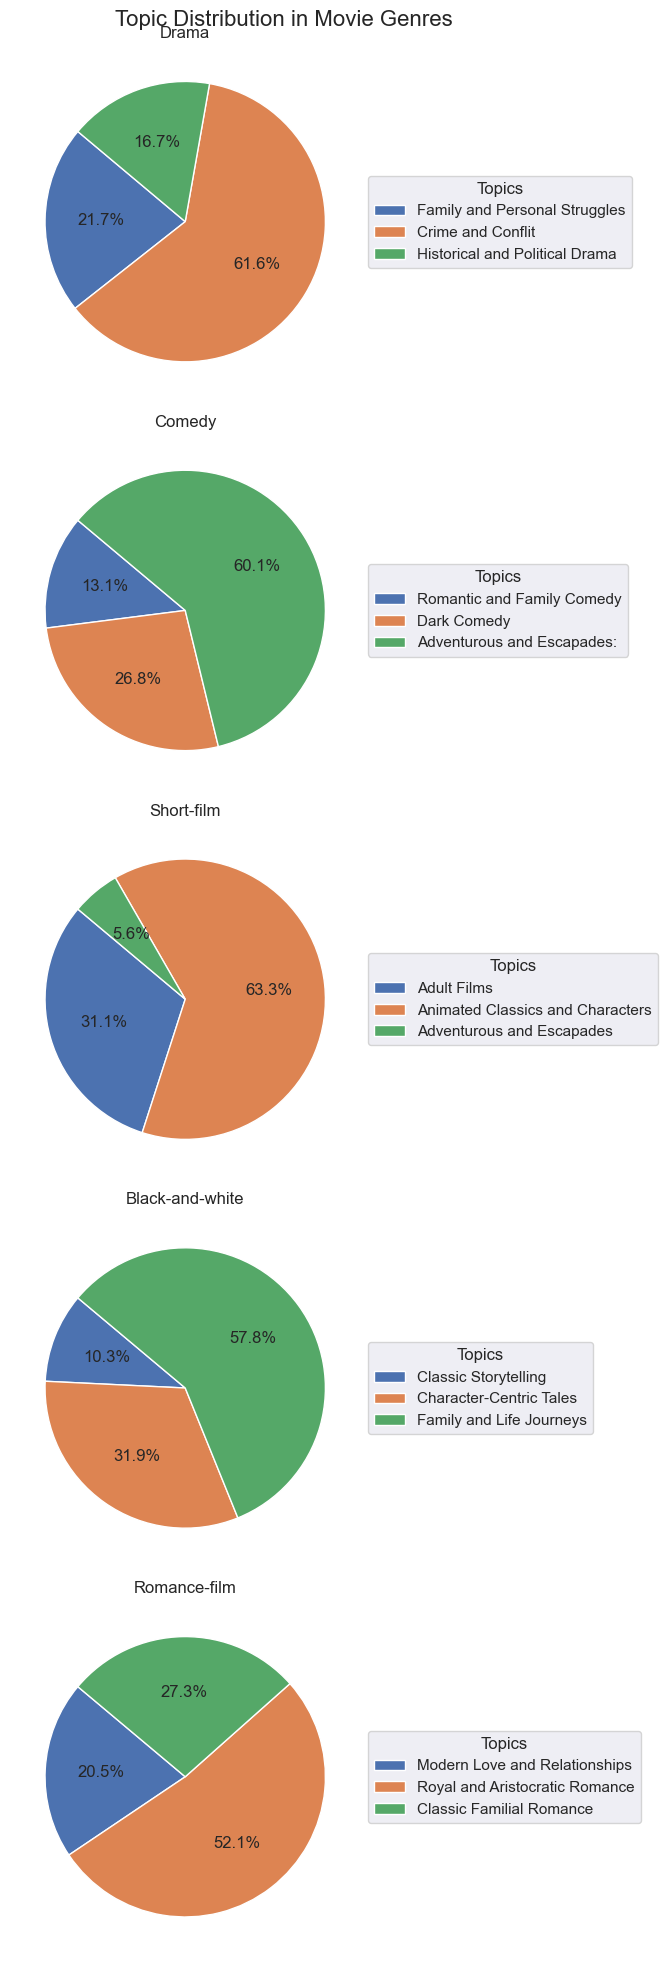

In [41]:
topics = {"Drama": ["Family and Personal Struggles", "Crime and Conflit", "Historical and Political Drama"],
            "Comedy": ["Romantic and Family Comedy", "Dark Comedy", "Adventurous and Escapades:"],
            "Short-film": ["Adult Films", "Animated Classics and Characters", "Adventurous and Escapades"],
            "Black-and-white": ["Classic Storytelling", "Character-Centric Tales", "Family and Life Journeys"],
            "Romance-film": ["Modern Love and Relationships", "Royal and Aristocratic Romance", "Classic Familial Romance"]}


# Plotting the pie charts in a vertical layout
fig, axes = plt.subplots(5, 1, figsize=(6, 20))  # Adjusted layout to vertical and size
fig.suptitle('Topic Distribution in Movie Genres', fontsize=16)

for i, (genre, counts) in enumerate(genre_topic_counts.items()):
    wedges, texts, autotexts = axes[i].pie(counts, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(genre)
    axes[i].legend(wedges, topics[genre], title="Topics", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()


We notice that the family topic is common within all the genres with a significant percentage. This suggests that the family tocpic might have an influcence with the good ranking of movies, therefore might be within the most appreciated topics by the film public.